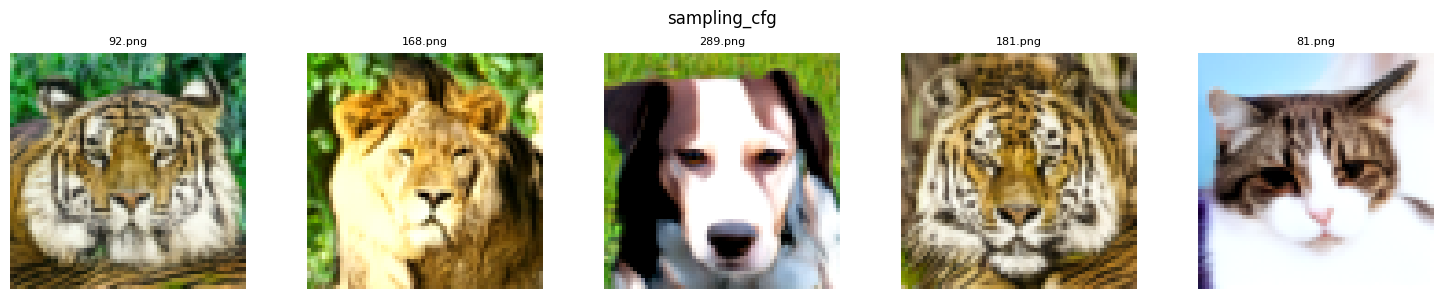

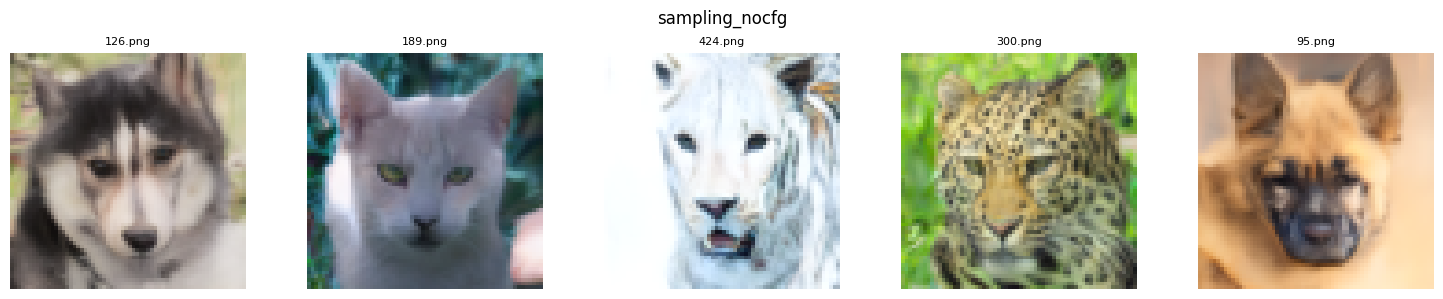

In [ ]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image

def list_images(dir_path, exts=(".png")):
    files = [p for p in glob.glob(os.path.join(dir_path, "*")) if os.path.splitext(p)[1].lower() in exts]
    return files

def show_random_images(dir_path, n=5, title=None):
    files = list_images(dir_path)
    k = min(n, len(files))
    sampled = random.sample(files, k) if len(files) >= k else files

    fig, axes = plt.subplots(1, k, figsize=(k * 3, 3))
    if k == 1:
        axes = [axes]
    for ax, path in zip(axes, sampled):
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(os.path.basename(path), fontsize=8)
        ax.axis('off')
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

BASE = "/home/reproducepark/workspace/Diffusion-Assignment2-DDIM-CFG"
DIR_CFG = os.path.join(BASE, "image_diffusion_todo/results/cfg_diffusion-ddpm-10-26-213913/sampling_cfg")
DIR_NO_CFG = os.path.join(BASE, "image_diffusion_todo/results/cfg_diffusion-ddpm-10-26-213913/sampling_nocfg")

show_random_images(DIR_CFG, n=5, title="sampling_cfg")
show_random_images(DIR_NO_CFG, n=5, title="sampling_nocfg")



In [9]:
!python ../../fid/measure_fid.py ../../data/afhq/eval ../../results/cfg_diffusion-ddpm-10-26-213913/sampling_nocfg

/home/reproducepark/anaconda3/envs/ddpm/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Calculating FID given paths ../../data/afhq/eval and ../../results/cfg_diffusion-ddpm-10-26-213913/sampling_nocfg...
/home/reproducepark/anaconda3/envs/ddpm/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/reproducepark/anaconda3/envs/ddpm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/reproducepark/anaconda3/envs/ddpm/lib/

In [10]:
!python ../../fid/measure_fid.py ../../data/afhq/eval ../../results/cfg_diffusion-ddpm-10-26-213913/sampling_cfg

/home/reproducepark/anaconda3/envs/ddpm/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Calculating FID given paths ../../data/afhq/eval and ../../results/cfg_diffusion-ddpm-10-26-213913/sampling_cfg...
/home/reproducepark/anaconda3/envs/ddpm/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/reproducepark/anaconda3/envs/ddpm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/reproducepark/anaconda3/envs/ddpm/lib/py

/home/reproducepark/anaconda3/envs/ddpm/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
100%|██████████| 1000/1000 [00:30<00:00, 32.95it/s]


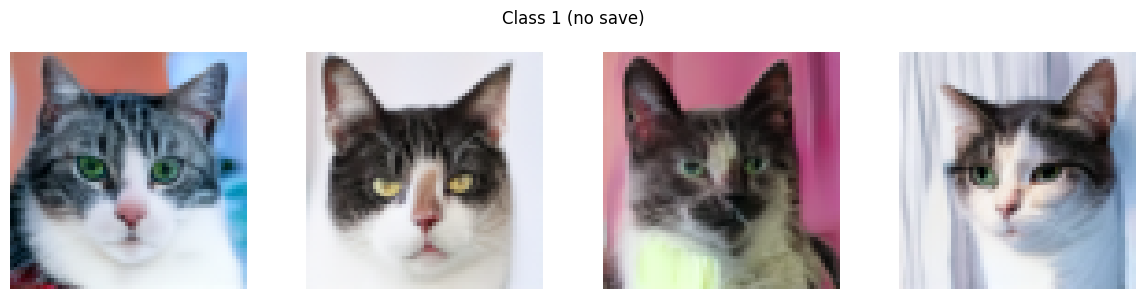

100%|██████████| 1000/1000 [00:29<00:00, 33.47it/s]


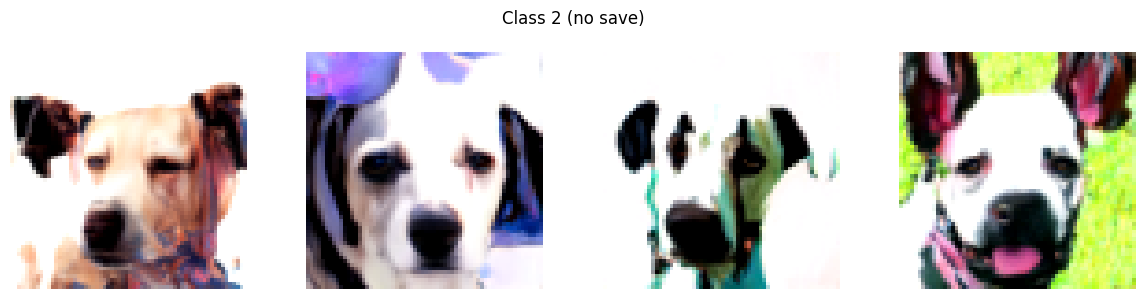

100%|██████████| 1000/1000 [00:29<00:00, 33.61it/s]


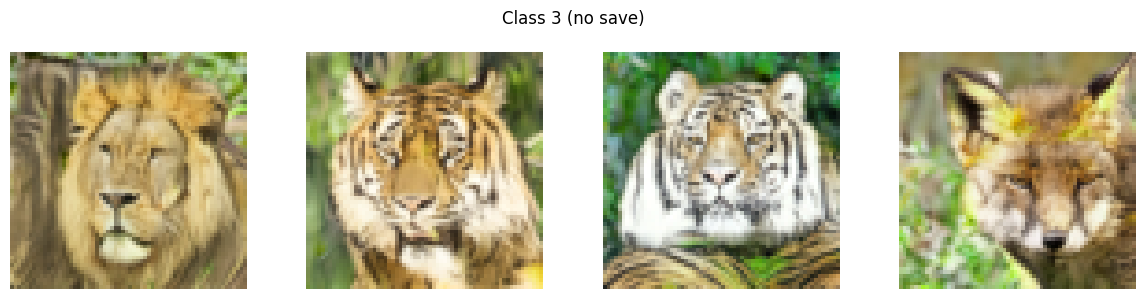

In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from PIL import Image

BASE = "/home/reproducepark/workspace/Diffusion-Assignment2-DDIM-CFG"
sys.path.append(BASE)

import image_diffusion_todo.module as _mod_mod
sys.modules['module'] = _mod_mod

import image_diffusion_todo.network as _net_mod
import image_diffusion_todo.scheduler as _sched_mod
sys.modules['network'] = _net_mod
sys.modules['scheduler'] = _sched_mod

from image_diffusion_todo.model import DiffusionModule
from image_diffusion_todo.scheduler import DDPMScheduler
from image_diffusion_todo.dataset import tensor_to_pil_image

CKPT = os.path.join(BASE, "image_diffusion_todo/results/cfg_diffusion-ddpm-10-26-213913/last.ckpt")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

def _ensure_model():
    global ddpm
    try:
        ddpm  # noqa: F821
    except NameError:
        ddpm = DiffusionModule(None, None)
        ddpm.load(CKPT)
        ddpm.eval()
        ddpm.to(device)
        num_train_timesteps = ddpm.var_scheduler.num_train_timesteps
        ddpm.var_scheduler = DDPMScheduler(
            num_train_timesteps, beta_1=1e-4, beta_T=0.02, mode="linear"
        ).to(device)


def sample_and_show(class_id: int, n: int = 4, use_cfg: bool = True, cfg_scale: float = 7.5, title: str | None = None):
    _ensure_model()
    labels = torch.full((n,), int(class_id), device=device, dtype=torch.long) if use_cfg else None
    guidance = cfg_scale if use_cfg else 0.0
    samples = ddpm.sample(n, class_label=labels, guidance_scale=guidance)
    pil_images = tensor_to_pil_image(samples)

    fig, axes = plt.subplots(1, len(pil_images), figsize=(len(pil_images) * 3, 3))
    if len(pil_images) == 1:
        axes = [axes]
    for ax, img in zip(axes, pil_images):
        ax.imshow(img)
        ax.axis("off")
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

sample_and_show(1, n=4, use_cfg=True, cfg_scale=7.5, title="Class 1 (no save)")
sample_and_show(2, n=4, use_cfg=True, cfg_scale=7.5, title="Class 2 (no save)")
sample_and_show(3, n=4, use_cfg=True, cfg_scale=7.5, title="Class 3 (no save)")
